# Project Overview
We propose to develop a machine learning solution to accurately forecast customer demand across multiple retail locations, optimizing inventory management and reducing operational inefficiencies. Using 25 months of historical sales data from four stores, we'll create predictive models that capture complex patterns in customer purchasing behavior, price sensitivity, and promotional impacts.

# Objectives
• Develop a machine learning model that accurately predicts product demand across multiple store locations.

• Identify Key Factors influencing customer purchasing patterns

• Understand the impact of pricing strategies, promotions and markdowns on sales volumes

## Data Sources  

The project integrates diverse data sources, including in-store and online sales, price changes, markdowns, promotional history, product catalog information, and store-specific details. Our analysis will leverage datasets spanning **25 months** of historical sales data from **four retail stores**:  

#### In-store Sales Data  
- **`sales.csv`**: Daily sales records including quantity sold, pricing, and revenue metrics  
#### Online Sales Data  
- **`online.csv`**: Store-specific e-commerce transaction data  
#### Pricing Information  
- **`price_history.csv`**: Historical price changes by product and store  
- **`markdowns.csv`**: Records of discounted product sales  
- **`discounts_history.csv`**: Detailed promotional pricing history  
#### Product Information  
- **`catalog.csv`**: Product details including department, class, and specifications  
- **`actual_matrix.csv`**: Store-specific product availability data  
#### Store Information  
- **`stores.csv`**: Comprehensive store details including format, location, and size  


In [176]:
# Importing Libraries

import numpy as np  # Numerical operations
import pandas as pd  # Data manipulation and analysis

#Data Visualization
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns  # Statistical visualizations
import plotly.express as px  # Interactive visualizations

# Data Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler  # Scaling numerical features
from sklearn.preprocessing import OneHotEncoder, LabelEncoder  # Encoding categorical data

# Time Series & Feature Engineering
import datetime as dt  # Date/time manipulation
from statsmodels.tsa.stattools import adfuller  # Stationarity test
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # ACF/PACF plots

# Machine Learning Models
from sklearn.model_selection import train_test_split  # Splitting data
from sklearn.ensemble import RandomForestRegressor  # Basic ML model
import xgboost as xgb  # XGBoost for regression
from sklearn.linear_model import LinearRegression  # Baseline model

# Model Evaluation
from sklearn.metrics import mean_squared_error  # RMSE calculation

# Handling Outliers & Missing Data
from scipy.stats import zscore  # Z-score for outlier detection



In [177]:
sales_df = pd.read_csv("sales.csv")
sales_df.head()

,Unnamed: 0,date,item_id,quantity,price_base,sum_total,store_id
0,0,2023-08-04,293375605257,1.000,47.86,47.86,1
1,1,2023-08-04,a66fdf2c0ae7,3.000,49.60,148.80,1
2,2,2023-08-04,daa46ef49b7a,0.822,379.00,311.54,1
3,3,2023-08-04,a3b49c1bf758,1.000,129.00,129.00,1
4,4,2023-08-04,ab611c5cef62,7.000,79.90,559.30,1


In [178]:
sales_df.info()
sales_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7432685 entries, 0 to 7432684
Data columns (total 7 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   date        object 
 2   item_id     object 
 3   quantity    float64
 4   price_base  float64
 5   sum_total   float64
 6   store_id    int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 396.9+ MB


Unnamed: 0    0
date          0
item_id       0
quantity      0
price_base    0
sum_total     0
store_id      0
dtype: int64

In [179]:
online_df = pd.read_csv("online.csv")
online_df.head()

,Unnamed: 0,date,item_id,quantity,price_base,sum_total,store_id
0,0,2023-08-04,4aa8dbe05246,3.0,12.40,37.21,1
1,1,2023-08-04,4e0fbcf99cf9,2.0,56.27,112.54,1
2,2,2023-08-04,2e008b673129,2.0,56.27,112.54,1
3,3,2023-08-04,49db9c973903,1.0,29.94,29.94,1
4,4,2023-08-04,9d6072422e8e,1.0,80.10,80.10,1


In [180]:
online_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1123412 entries, 0 to 1123411
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   Unnamed: 0  1123412 non-null  int64  
 1   date        1123412 non-null  object 
 2   item_id     1123412 non-null  object 
 3   quantity    1123412 non-null  float64
 4   price_base  1123412 non-null  float64
 5   sum_total   1123412 non-null  float64
 6   store_id    1123412 non-null  int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 60.0+ MB


In [181]:
pricehist_df = pd.read_csv("price_history.csv")
pricehist_df.head()

,Unnamed: 0,date,item_id,price,code,store_id
0,0,2023-08-01,4a1f95fe4d4b,499.9,1,1
1,1,2023-08-01,bf43a9d3ae13,0.0,9999999999,1
2,2,2023-08-01,0dd8744decce,129.9,1,1
3,3,2023-08-01,9b38c7e4dba9,136.0,1,1
4,4,2023-08-01,b791e8c9347c,0.0,1,1


In [182]:
pricehist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698626 entries, 0 to 698625
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  698626 non-null  int64  
 1   date        698626 non-null  object 
 2   item_id     698626 non-null  object 
 3   price       698626 non-null  float64
 4   code        698626 non-null  int64  
 5   store_id    698626 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 32.0+ MB


In [183]:
markdown_df = pd.read_csv("markdowns.csv")
markdown_df.head()

,Unnamed: 0,date,item_id,normal_price,price,quantity,store_id
0,0,2023-08-01,bc2f82a22e11,189.0,100.0,8.0,1
1,1,2023-08-01,389412076801,179.0,100.0,5.0,1
2,2,2023-08-01,0e39cf5d57c1,149.0,100.0,5.0,1
3,3,2023-08-01,dd94e2bc5601,149.0,100.0,1.0,1
4,4,2023-08-01,e60d890f2812,369.0,270.0,1.0,1


In [184]:
markdown_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8979 entries, 0 to 8978
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    8979 non-null   int64  
 1   date          8979 non-null   object 
 2   item_id       8979 non-null   object 
 3   normal_price  8979 non-null   float64
 4   price         8979 non-null   float64
 5   quantity      8979 non-null   float64
 6   store_id      8979 non-null   int64  
dtypes: float64(3), int64(2), object(2)
memory usage: 491.2+ KB


In [185]:
dischist_df = pd.read_csv("discounts_history.csv")
dischist_df.head()

,Unnamed: 0,date,item_id,sale_price_before_promo,sale_price_time_promo,promo_type_code,doc_id,number_disc_day,store_id
0,3648316,2022-08-28,cde97a9ec3ef,729.9,669.9,6.0,89ea9f0c-1c08-11ed-ad4d-005056861040,13.0,1
1,3648317,2022-08-28,2906fbc9e11c,129.9,99.9,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0,1
2,3648318,2022-08-28,c48c3a3d8c01,129.9,99.9,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0,1
3,3648319,2022-08-28,f85243ca61e6,129.9,99.9,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0,1
4,3648320,2022-08-28,27ce75534065,129.9,99.9,NaN,039e85df-1e51-11ed-ad4d-005056861040,11.0,1


In [186]:
dischist_df.info()
dischist_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3746744 entries, 0 to 3746743
Data columns (total 9 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Unnamed: 0               int64  
 1   date                     object 
 2   item_id                  object 
 3   sale_price_before_promo  float64
 4   sale_price_time_promo    float64
 5   promo_type_code          float64
 6   doc_id                   object 
 7   number_disc_day          float64
 8   store_id                 int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 257.3+ MB


Unnamed: 0                      0
date                            0
item_id                         0
sale_price_before_promo         0
sale_price_time_promo           0
promo_type_code            317846
doc_id                          0
number_disc_day                 0
store_id                        0
dtype: int64

In [187]:
catalog_df = pd.read_csv("english_catalog.csv")
catalog_df.head()

,Unnamed: 0,item_id,dept_name,class_name,subclass_name,item_type,weight_volume,weight_netto,fatness
0,0,da17e2d5feda,Paper products,Paper products,Wet napkins,NaN,150.0,NaN,NaN
1,1,614de2b96018,Paper products,Cotton products,Cotton wheels,NaN,30.0,NaN,NaN
2,2,0c1f1f3e3e11,Paper products,Cotton products,Cotton wheels,NaN,NaN,NaN,NaN
3,3,71a7fa99f005,Home goods,Vessel,COOKWARE,NaN,NaN,NaN,NaN
4,4,ec1bd4d59fe9,Paper products,Cotton products,Cotton wheels,NaN,30.0,NaN,NaN


In [188]:
catalog_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219810 entries, 0 to 219809
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Unnamed: 0     219810 non-null  int64  
 1   item_id        219810 non-null  object 
 2   dept_name      219810 non-null  object 
 3   class_name     219810 non-null  object 
 4   subclass_name  219810 non-null  object 
 5   item_type      43586 non-null   object 
 6   weight_volume  82952 non-null   float64
 7   weight_netto   48957 non-null   float64
 8   fatness        7212 non-null    float64
dtypes: float64(3), int64(1), object(5)
memory usage: 15.1+ MB


In [189]:
actmatr_df = pd.read_csv("actual_matrix.csv")
actmatr_df.head()

,Unnamed: 0,item_id,date,store_id
0,0,c578da8e8841,2019-10-17,1
1,1,4dd2b686802c,2019-10-17,1
2,2,16ade2e3fca9,2019-10-17,1
3,3,f4eb16dab09e,2019-10-17,1
4,4,ab1384c2af6d,2020-05-31,1


In [190]:
actmatr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35202 entries, 0 to 35201
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  35202 non-null  int64 
 1   item_id     35202 non-null  object
 2   date        35202 non-null  object
 3   store_id    35202 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.1+ MB


In [191]:
stores_df = pd.read_csv("stores.csv")
stores_df.head()

,Unnamed: 0,store_id,division,format,city,area
0,0,4,Div1,MaxiEuro,City3,1887
1,1,3,Div2,Format-7 express,City2,109
2,2,2,Div2,Format-6,City1,210
3,3,1,Div1,Format-1,City1,1500


In [192]:
stores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4 non-null      int64 
 1   store_id    4 non-null      int64 
 2   division    4 non-null      object
 3   format      4 non-null      object
 4   city        4 non-null      object
 5   area        4 non-null      int64 
dtypes: int64(3), object(3)
memory usage: 324.0+ bytes


In [193]:
def preprocess_data(df, drop_index=True, date_cols=None):
    """
    Cleans and preprocesses the given dataframe by:
    1. Dropping the 'Unnamed: 0' column if present.
    2. Converting date columns to datetime format.
    3. Filling missing categorical values with 'unknown'.
    4. Checking skewness of numerical columns.
    5. Applying log1p transformation to highly skewed numerical columns.
    6. Filling missing numerical values after transformation.
    
    Returns:
        - Cleaned DataFrame
        - Skewness of numerical columns
    """
    
    # Drop 'Unnamed: 0' if it exists
    if drop_index and "Unnamed: 0" in df.columns:
        df = df.drop(columns=["Unnamed: 0"])
    
    # Convert date columns to datetime format
    if date_cols:
        for col in date_cols:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors="coerce").dt.strftime('%Y-%m')
                
    # Fill missing categorical values
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].fillna("unknown")
    
    # Check skewness before filling missing values
    num_cols = df.select_dtypes(include=["int64", "float64"]).columns
    skew_values = df[num_cols].skew()
    
    # Identify highly skewed columns (>|1.0|) except store_id, code, promo_type_code
    excluded_cols = ["store_id", "code", "promo_type_code"]  # Add any others if needed
    skewed_cols = [col for col in skew_values[abs(skew_values) > 1].index if col not in excluded_cols]
    
    # Apply log1p transformation, ensuring no negative values
    for col in skewed_cols:
        if df[col].min() < 0:
            df[col] = np.log1p(df[col] - df[col].min() + 1)  # Shift negatives before log
        else:
            df[col] = np.log1p(df[col])
    
    # Now, fill missing numerical values after transformation
    for col in num_cols:
        if df[col].isnull().sum() > 0:
            if abs(skew_values[col]) > 1:  # Highly skewed? Use median
                df[col] = df[col].fillna(df[col].median())
            else:  # Normal? Use mean
                df[col] = df[col].fillna(df[col].mean())

    return df, skew_values


🔹 Correlation Heatmap for Sales Data


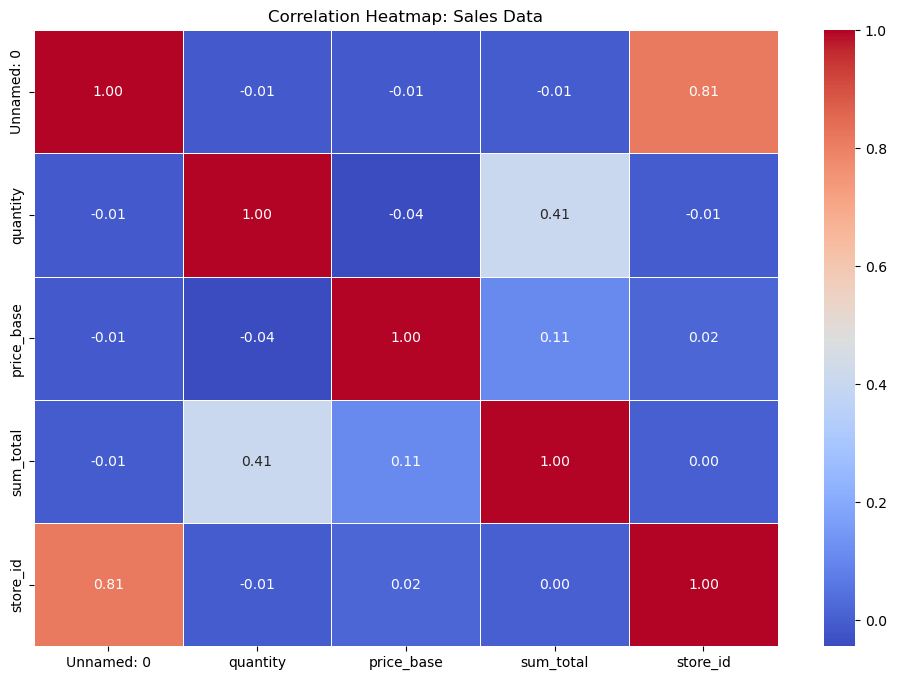

🔹 Correlation Heatmap for Online Sales


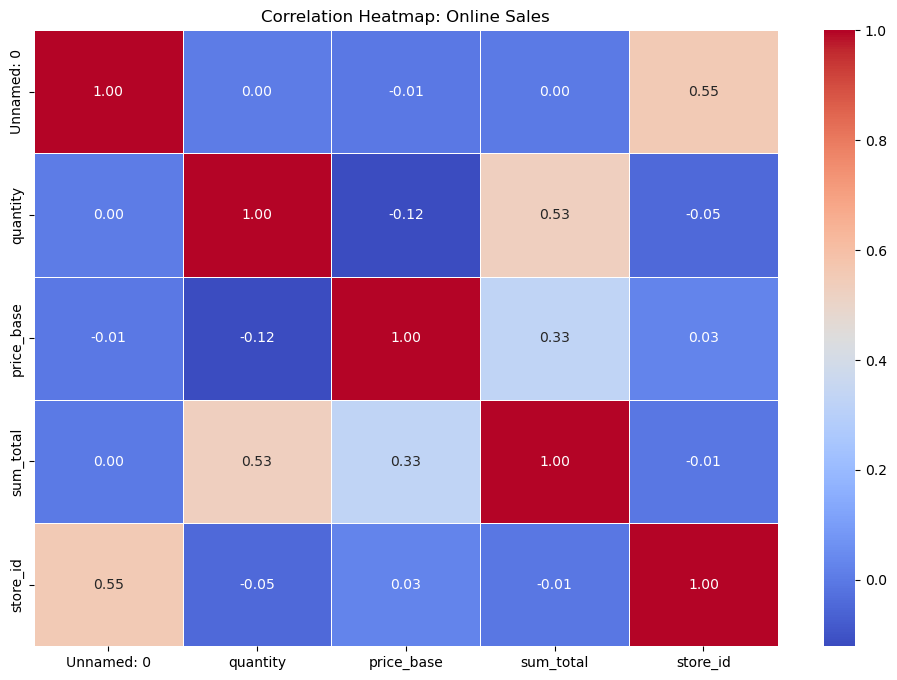

🔹 Correlation Heatmap for Markdown Prices


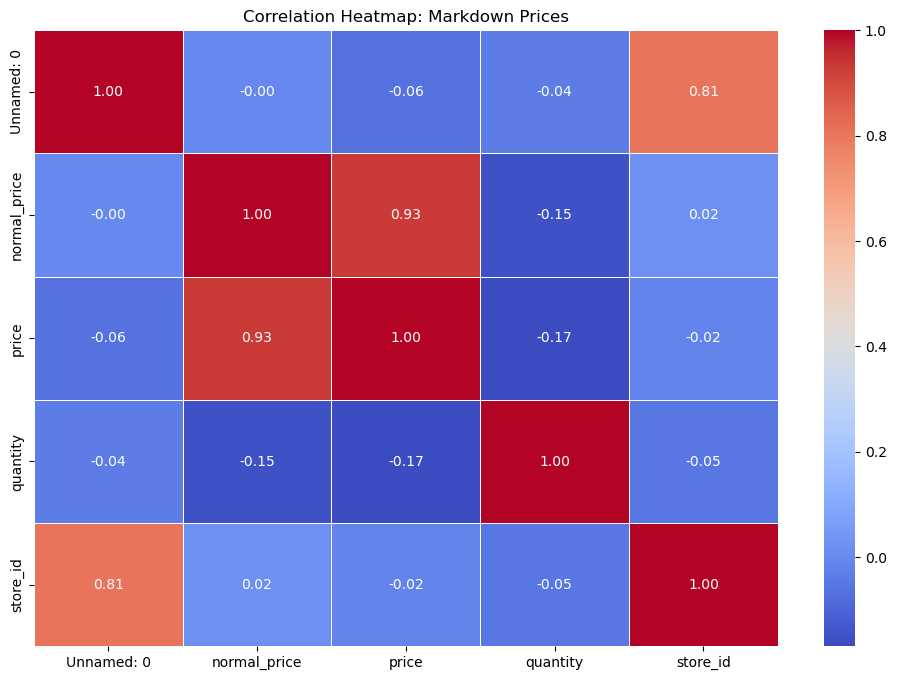

In [194]:
def plot_correlation_heatmap(df, title):
    plt.figure(figsize=(12, 8))
    corr_matrix = df.corr(numeric_only=True)  # Compute correlation
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(f"Correlation Heatmap: {title}")
    plt.show()

# Apply to each dataset
datasets = {
    "Sales Data": sales_df,
    "Online Sales": online_df,
    "Markdown Prices": markdown_df,
}

for name, df in datasets.items():
    print(f"🔹 Correlation Heatmap for {name}")
    plot_correlation_heatmap(df, name)


In [195]:
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r_corr, k_corr = confusion_matrix.shape
    denom = min((r_corr - 1), (k_corr - 1))

    return np.sqrt(chi2 / (n * denom)) if denom > 0 else np.na

def cramers_v_matrix(df):
    cat_cols = df.select_dtypes(include=['object']).columns
    if len(cat_cols) < 2:
        return None  # Not enough categorical columns to compute correlations

    n = len(cat_cols)
    cramers_results = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            if i == j:
                cramers_results[i, j] = 1  # Correlation of a variable with itself is 1
            else:
                cramers_results[i, j] = cramers_v(df[cat_cols[i]], df[cat_cols[j]])
    
    return pd.DataFrame(cramers_results, index=cat_cols, columns=cat_cols)

def plot_cramers_v_heatmap(df, title):
    cramers_matrix = cramers_v_matrix(df)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cramers_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title(f"Cramér's V Heatmap: {title}")
    plt.show()

# Compute and plot for catalog_df
plot_cramers_v_heatmap(catalog_df, "Product Catalog")



MemoryError: Unable to allocate 1.62 GiB for an array with shape (219810, 989) and data type float64

In [196]:
# Clean sales data
sales_df, sales_skew = preprocess_data(sales_df)
sales_df.rename(columns={"quantity" :"quantity_sales"}, inplace=True)

# Clean online sales data
online_df, online_skew = preprocess_data(online_df)
online_df = online_df.drop(columns=['price_base', 'sum_total'])
online_df.rename(columns={'quantity':"quantity_online"}, inplace=True)

# Clean price history
pricehist_df, pricehist_skew = preprocess_data(pricehist_df)
pricehist_df = pricehist_df.drop(columns=["code"])

# Clean markdowns
markdown_df, markdown_skew = preprocess_data(markdown_df)
markdown_df['markdown_price'] = markdown_df['normal_price'] - markdown_df['price']
markdown_df = markdown_df.drop(columns=['normal_price', 'price'])
markdown_df.rename(columns={"quantity": "quantity_markdown"}, inplace=True)

# Clean discount history
dischist_df, dischist_skew = preprocess_data(dischist_df)
dischist_df = dischist_df.drop(columns=["doc_id", "number_disc_day", "promo_type_code"])
dischist_df["promo_amount"] = dischist_df["sale_price_before_promo"] - dischist_df["sale_price_time_promo"]
dischist_df = dischist_df.drop(columns=["sale_price_before_promo", "sale_price_time_promo" ])

# Clean product catalog (no date column)
catalog_df, catalog_skew = preprocess_data(catalog_df, drop_index=True)
catalog_df = catalog_df.drop(columns=["weight_netto", "subclass_name", "class_name"])

# Clean actual matrix
actmatr_df, actmatr_skew = preprocess_data(actmatr_df)

# Clean stores data (no date column)
stores_df, stores_skew = preprocess_data(stores_df, drop_index=True)
stores_df = stores_df.drop(columns=["city"])


In [197]:
# Apply the exponential function to restore original values
online_df["store_id"] = np.exp(online_df["store_id"])

# Convert to integers safely
online_df["store_id"] = online_df["store_id"].round().astype("Int64")

# Check unique values before fixing
print(markdown_df["store_id"].unique())

# Convert store_id to numeric (forcing errors='coerce' converts non-numeric values to NaN)
markdown_df["store_id"] = pd.to_numeric(markdown_df["store_id"], errors='coerce')

# Reverse the log transformation if needed
if markdown_df["store_id"].between(0.5, 2).all():  # Assuming store IDs should be whole numbers
    markdown_df["store_id"] = np.exp(markdown_df["store_id"])

# Round and convert to integers safely
markdown_df["store_id"] = markdown_df["store_id"].round().astype("Int64")

# Check again
print(markdown_df["store_id"].unique())



[1 2 4]
<IntegerArray>
[1, 2, 4]
Length: 3, dtype: Int64


In [198]:
# Convert store_id to integers where applicable
sales_df["store_id"] = sales_df["store_id"].astype("Int64")
online_df["store_id"] = online_df["store_id"].astype("Int64")
pricehist_df["store_id"] = pricehist_df["store_id"].astype("Int64")
dischist_df["store_id"] = dischist_df["store_id"].astype("Int64")
markdown_df["store_id"] = markdown_df["store_id"].astype("Int64")
stores_df["store_id"] = stores_df["store_id"].astype("Int64")

# Convert item_id to strings (object) for consistency
sales_df["item_id"] = sales_df["item_id"].astype(str)
online_df["item_id"] = online_df["item_id"].astype(str)
pricehist_df["item_id"] = pricehist_df["item_id"].astype(str)
dischist_df["item_id"] = dischist_df["item_id"].astype(str)
markdown_df["item_id"] = markdown_df["item_id"].astype(str)
catalog_df["item_id"] = catalog_df["item_id"].astype(str)

# Convert date columns to datetime for proper merging
sales_df["date"] = pd.to_datetime(sales_df["date"])
online_df["date"] = pd.to_datetime(online_df["date"])
pricehist_df["date"] = pd.to_datetime(pricehist_df["date"])
dischist_df["date"] = pd.to_datetime(dischist_df["date"])
markdown_df["date"] = pd.to_datetime(markdown_df["date"])



In [199]:
# Step 1: Combine sales_df and online_df
sales_data = pd.concat([sales_df, online_df], ignore_index=True)

# Step 2: Merge with price history, markdown, discount history, and active matrix
datasets = [markdown_df, dischist_df]
merge_cols = ['item_id', 'store_id', 'date']

for df in datasets:
    sales_data = sales_data.merge(df, on=merge_cols, how='left')

# Step 3: Merge with product catalog and store details
sales_data = sales_data.merge(catalog_df, on='item_id', how='left')
sales_data = sales_data.merge(stores_df, on='store_id', how='left')

# Step 4: Fill missing values where possible
sales_data.fillna(method='ffill', inplace=True)

# Check final structure
print(sales_data.info())
sales_data.head()


MemoryError: cannot allocate memory for array

In [ ]:
sales_data = sales_data.drop(columns=["item_id", "store_id", "quantity_online"])

In [ ]:
sales_data["area"].unique()

array([1500,  210,  109, 1887], dtype=int64)

In [ ]:
sales_data.isnull().sum()

date                   0
quantity_sales         0
price_base             0
sum_total              0
quantity_markdown    273
markdown_price       273
promo_amount          10
dept_name              0
item_type              0
weight_volume          0
fatness                0
division               0
format                 0
area                   0
dtype: int64

In [200]:
sales_data.loc[:, ["quantity_markdown", "markdown_price", "promo_amount"]] = \
    sales_data.loc[:, ["quantity_markdown", "markdown_price", "promo_amount"]].fillna(0)


KeyError: "None of [Index(['quantity_markdown', 'markdown_price', 'promo_amount'], dtype='object')] are in the [columns]"

In [201]:
# Check how many negative values exist in each column
neg_counts = {
    "price_base": (sales_data['price_base'] < 0).sum(),
    "markdown_price": (sales_data['markdown_price'] < 0).sum(),
    "promo_amount": (sales_data['promo_amount'] < 0).sum()
}

print("Negative Value Counts:", neg_counts)

# Display rows with negative values
df_negatives = sales_data[(sales_data['price_base'] < 0) | (sales_data['markdown_price'] < 0) | (sales_data['promo_amount'] < 0)]
print(df_negatives.head(10))  # Show first 10 rows


KeyError: 'markdown_price'

In [ ]:
sales_data['markdown_price'] = sales_data['markdown_price'].abs()
sales_data['promo_amount'] = sales_data['promo_amount'].abs()

# Impact of Promotions on Sales

C:\Users\USER\AppData\Local\Temp\ipykernel_17500\198850531.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  markdown_sales = sales_data.groupby('markdown_bins')['quantity_sales'].mean()


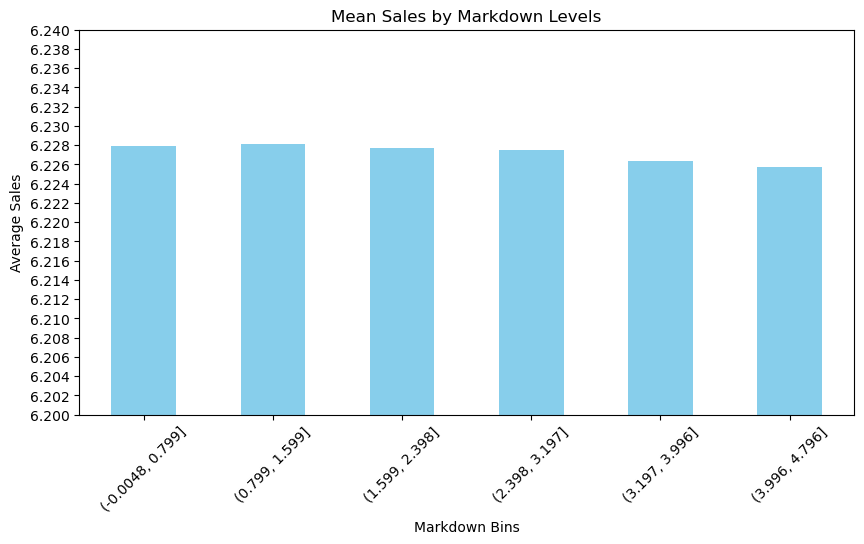

C:\Users\USER\AppData\Local\Temp\ipykernel_17500\198850531.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promo_sales = sales_data.groupby('promo_bins')['quantity_sales'].mean()


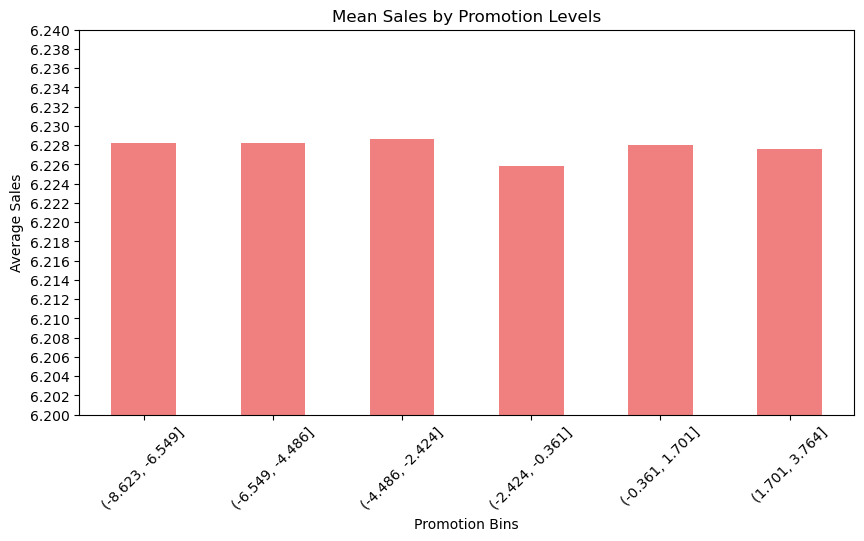

In [ ]:
# Create bins for markdowns and promotions
sales_data['markdown_bins'] = pd.cut(sales_data['quantity_markdown'], bins=6)
sales_data['promo_bins'] = pd.cut(sales_data['promo_amount'], bins=6)

# Mean sales per markdown bin
markdown_sales = sales_data.groupby('markdown_bins')['quantity_sales'].mean()

plt.figure(figsize=(10, 5))
markdown_sales.plot(kind='bar', color='skyblue')
plt.title("Mean Sales by Markdown Levels")
plt.xlabel("Markdown Bins")
plt.ylabel("Average Sales")
plt.ylim(6.2, 6.24)  # Start at 6, end at 7
plt.yticks(np.arange(6.2, 6.24, 0.002))   # Small increments of 0.02
plt.xticks(rotation=45)
plt.show()

# Mean sales per promotion bin
promo_sales = sales_data.groupby('promo_bins')['quantity_sales'].mean()

plt.figure(figsize=(10, 5))
promo_sales.plot(kind='bar', color='lightcoral')
plt.title("Mean Sales by Promotion Levels")
plt.xlabel("Promotion Bins")
plt.ylabel("Average Sales")
plt.ylim(6.2, 6.24)  # Start at 6, end at 7
plt.yticks(np.arange(6.2, 6.24, 0.002))  # Small increments of 0.02
plt.xticks(rotation=45)
plt.show()


# Sales by Category

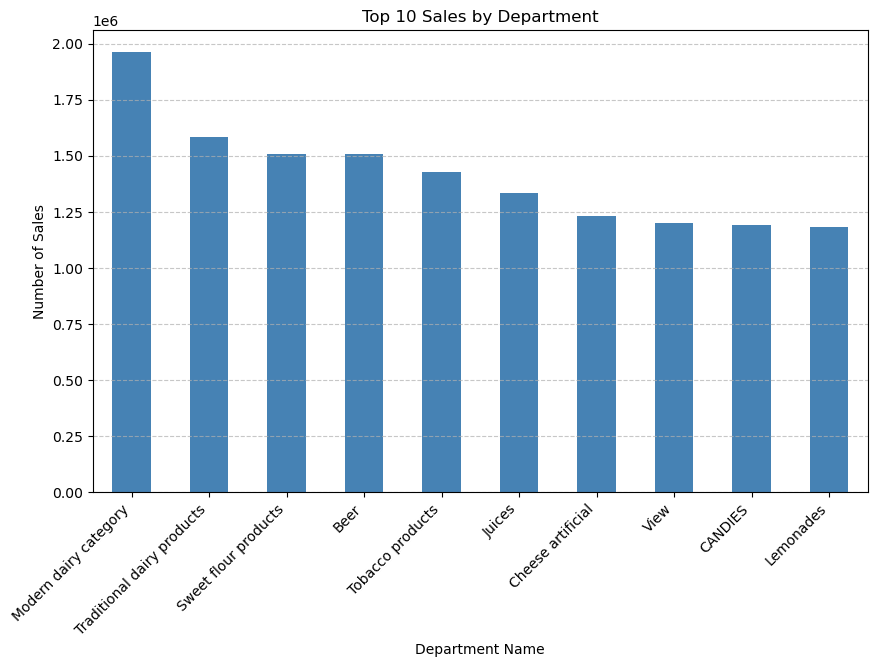

In [ ]:
# Sort departments by sales and select the top 10
top_10_departments = sales_data.groupby("dept_name")["quantity_sales"].sum().nlargest(10)

# Plot
plt.figure(figsize=(10, 6))
top_10_departments.plot(kind="bar", color="steelblue")

# Formatting
plt.title("Top 10 Sales by Department")
plt.xlabel("Department Name")
plt.ylabel("Number of Sales")
plt.xticks(rotation=45, ha="right")  # Rotate labels for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show the plot
plt.show()


# Time Series Analysis

C:\Users\USER\AppData\Local\Temp\ipykernel_17500\2852565133.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='date', y='quantity_sales', data=sales_data, ci=None)


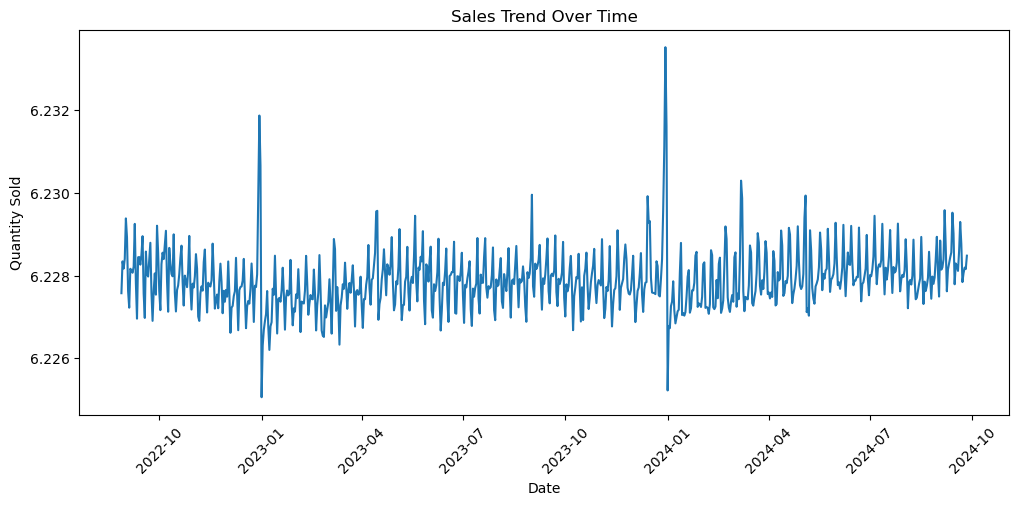

In [ ]:
plt.figure(figsize=(12, 5))
sns.lineplot(x='date', y='quantity_sales', data=sales_data, ci=None)
plt.title("Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.xticks(rotation=45)
plt.show()

# FEATURE ENGINEERING

Exponential Weighted Moving Average (EWMA)

In [ ]:
# Apply EWMA to smooth sales trends
sales_data['ewma_7_sales'] = sales_data.groupby('area')['quantity_sales'].transform(lambda x: x.ewm(span=7, adjust=False).mean())


Lag Features

In [ ]:
# Create lag features for past sales
sales_data['lag_1_sales'] = sales_data.groupby('area')['quantity_sales'].shift(1)  # Yesterday's sales
sales_data['lag_7_sales'] = sales_data.groupby('area')['quantity_sales'].shift(7)  # Sales 7 days ago
sales_data['lag_14_sales'] = sales_data.groupby('area')['quantity_sales'].shift(14)  # Sales 14 days ago


Area Feature

In [ ]:
sales_data = pd.get_dummies(sales_data, columns=['area'], prefix='area')

KeyError: "None of [Index(['area'], dtype='object')] are in the [columns]"

In [ ]:
area_sales = sales_data.groupby('area')['quantity_sales'].mean().rename('avg_sales_per_area')

# Merge back into the dataset
sales_data = sales_data.merge(area_sales, on='area', how='left')


KeyError: 'area'